In [1]:
import pandas as pd, re, os, matplotlib.pyplot as plt, numpy as np, collections, itertools, tqdm
import sklearn.metrics as metrics
from statsmodels import api
from scipy import stats
from matplotlib import rcParams
rcParams['font.family'] = "P052"
try:
    pass
    %load_ext autoreload
    %autoreload 2
    %config InlineBackend.figure_format = 'svg'
except SyntaxError:
    pass

os.chdir("/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/discovery/nature_atlas/")
OUR_RESULTS_FILE = "../../out/results_2023-02-22@22`44`25.2@+00`00.csv"
THEIR_RESULTS_FILE = "./41586_2022_5575_MOESM5_ESM.csv"

In [2]:
correctly_sort_index = lambda index: \
    [
        (x.split("|")[0],
        x.split("|")[1],
        np.mean([int(y[1:]) for y in eval(x.split("|")[2])])
        )
        for x in index
    ]

def efficient_get_pctl(arr, round_to=1):
    sorted_order = np.argsort(arr)
    arr_sorted = arr[sorted_order]
    tot_len = len(arr)
    res = []
    i = 0
    while i < tot_len:
        num_bigger_than = i
        pctl_strict_bigger = num_bigger_than * 100 / tot_len
        next_diff_value = i + 1
        while next_diff_value < tot_len and arr_sorted[next_diff_value] == arr_sorted[i]:
            next_diff_value += 1
        res += [pctl_strict_bigger] * (next_diff_value - i)

        i += next_diff_value - i
    return np.round(np.array(res)[np.argsort(sorted_order)], round_to)

def efficient_get_pctl_2d(arr, round_to=1):
    res = []
    for a in arr.T:
        res.append(efficient_get_pctl(a, round_to))
    return np.asarray(res).T

In [3]:
results = pd.read_csv(OUR_RESULTS_FILE)
results["KinSymbol"] = results["Kinase Gene Name"] + "|" + results["Kinase Uniprot Accession"]
results["SiteSymbol"] = (
    results["Site Gene Name"] + "|" + results["Site Uniprot Accession"] + "|" + results["Site Location"]
)
results = results[["KinSymbol", "SiteSymbol", "Score"]]
kin_to_site_to_score = results.set_index(["KinSymbol", "SiteSymbol"]).to_dict()["Score"]
cols = {x: {} for x in results["KinSymbol"].unique()}
for (kin, site), score in kin_to_site_to_score.items():
    cols[kin][site] = score
orig_keys = list(cols.keys())
for c in orig_keys:
    cols[c + "^Score"] = cols.pop(c)
derived_df = pd.DataFrame.from_dict(cols)
percentiled: np.ndarray = efficient_get_pctl_2d(derived_df.values)
for col in derived_df.columns:
    assert isinstance(col, str)
    derived_df[col + "^Pctl"] = percentiled[:, derived_df.columns.get_loc(col)]
derived_df = derived_df.drop(columns=[col for col in derived_df.columns if "^Pctl" not in str(col)], inplace=False)
derived_df.sort_index(axis='index', key=correctly_sort_index, inplace=True)
ranked = (
    derived_df.rank(axis=1, method="min")
    .rename(columns={c: str(c).replace("^Score", "^Rank") for c in derived_df.columns})
    .astype(int)
)
our_df_to_compare = pd.concat([derived_df, ranked], axis=1)
our_df_to_compare = our_df_to_compare[
    list(
        itertools.chain(
            *[
                [base_c, str(base_c).replace("^Score", "^Rank")]
                for base_c in our_df_to_compare.columns[: len(our_df_to_compare.columns) // 2]
            ]
        )
    )
]
our_df_to_compare = our_df_to_compare.sort_index(axis='columns')
our_ranks = our_df_to_compare[[x for x in our_df_to_compare.columns if "Rank" in str(x)]].copy()
our_ranks = our_ranks.sort_index(axis='index', key=correctly_sort_index, inplace=False)
our_ranks.to_csv("./our_ranks.csv")


In [4]:
derived_df.to_csv("./our_percentiles.csv")

In [5]:
their_results = pd.read_csv(THEIR_RESULTS_FILE).set_index("Uniprot Primary Accession")
matrix_name_to_uniprot_id: dict[str, str] = (
    pd.read_csv("./41586_2022_5575_MOESM3_ESM.csv").set_index("Matrix_name").to_dict()["Uniprot id"]
)

their_site_flk_seqs_to_locs = collections.defaultdict(list[str])
their_site_flk_seqs_to_upids = collections.defaultdict(list[str])
their_site_flk_seqs_to_genes = collections.defaultdict(list[str])
for i, r in their_results.iterrows():
    flk_seq = r["SITE_+/-7_AA"]  # flk_seq.split("|")
    their_site_flk_seqs_to_locs[flk_seq].append(r["Phosphosite"])
    their_site_flk_seqs_to_upids[flk_seq].append(str(i))  # AKA Uniprot ID
    their_site_flk_seqs_to_genes[flk_seq].append(r["Gene"] if not pd.isna(r["Gene"]) else f"<UNK>UnipAc:{i}")

# Argsort each of the defaultdicts by the uniprot id
for flk_seq in their_site_flk_seqs_to_locs:
    argst = np.argsort(their_site_flk_seqs_to_upids[flk_seq])
    their_site_flk_seqs_to_locs[flk_seq] = [their_site_flk_seqs_to_locs[flk_seq][i] for i in argst]
    their_site_flk_seqs_to_upids[flk_seq] = [their_site_flk_seqs_to_upids[flk_seq][i] for i in argst]
    their_site_flk_seqs_to_genes[flk_seq] = [their_site_flk_seqs_to_genes[flk_seq][i] for i in argst]

their_sites_to_symbols = {
    flk: f"""{their_site_flk_seqs_to_genes[flk]}|{their_site_flk_seqs_to_upids[flk]}|{their_site_flk_seqs_to_locs[flk]}"""
    for flk in their_site_flk_seqs_to_locs
}
new_idx = [their_sites_to_symbols[r["SITE_+/-7_AA"]] for _, r in their_results.iterrows()]
their_results.index = pd.Index(new_idx)

their_kins_to_symbols = {
    tk: f"['{re.sub(r'_rank', r'', tk)}']|['{matrix_name_to_uniprot_id[re.sub(r'_rank', r'', tk)]}']^Rank^Pctl"
    for tk in [str(x) for x in their_results.columns]
    if tk.endswith("_rank")
}
their_kins_to_symbols_pctls = {
    tk: f"['{re.sub(r'_percentile', r'', tk)}']|['{matrix_name_to_uniprot_id[re.sub(r'_percentile', r'', tk)]}']^Pctl^Pctl"
    for tk in [str(x) for x in their_results.columns]
    if tk.endswith("_percentile") and "median" not in tk
}
their_df_to_compare = their_results.rename(columns=their_kins_to_symbols)[list(their_kins_to_symbols.values())]
their_df_percentiles = their_results.rename(columns=their_kins_to_symbols_pctls)[list(their_kins_to_symbols_pctls.values())]
their_ranks = their_df_to_compare[our_ranks.columns].copy()
their_ranks = their_ranks.rank(axis=1, method="max").astype(int)
their_ranks.sort_index(axis="index", key=correctly_sort_index, inplace=True)
normalize_ranks = lambda obj_to_norm, starting_ranks, ending_ranks: obj_to_norm*(ending_ranks-1)/(starting_ranks-1) + (starting_ranks-ending_ranks)/(starting_ranks-1)
# their_ranks.shape, our_ranks.shape, set(our_ranks.index) == set(their_ranks.index)
their_ranks = their_ranks[~their_ranks.index.duplicated()] # TODO: handle repeats better
assert set(our_ranks.index) == set(their_ranks.index), "The set of indices (symbols) are not the same between our ranks and their ranks"
their_ranks.insert(0, column='fake_idx', value = their_ranks.index, allow_duplicates=True)
their_ranks = their_ranks.drop_duplicates(keep='first').drop(columns=['fake_idx'])
their_ranks.to_csv("./their_ranks.csv")

In [6]:
their_df_percentiles.sort_index(axis="index", key=correctly_sort_index, inplace=True)

In [7]:
their_df_percentiles = their_df_percentiles[[str(x).replace("^Rank", "^Pctl") for x in our_ranks.columns]]
their_df_percentiles = their_df_percentiles[~their_df_percentiles.index.duplicated()]
their_df_percentiles.to_csv("./their_percentiles.csv")

In [8]:
assert np.all(their_df_percentiles.index == derived_df.index), "The indices (symbols) are not the same between our percentiles and their percentiles"

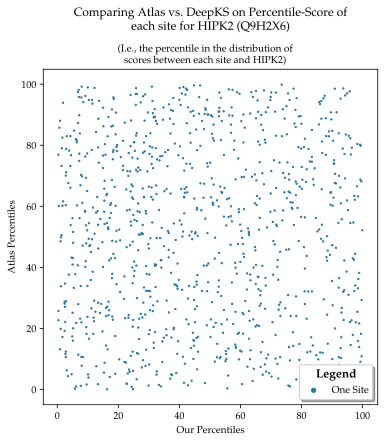

In [152]:
import random, textwrap as tw
fig = plt.figure(figsize=(6, 8))

KIN = str(their_df_percentiles.columns[5])
inds = list(range(len(their_df_percentiles[KIN])))
inds = random.sample(inds, k=1000)
_ = plt.gca().set_aspect(1)
X = derived_df[KIN.replace("]^Pctl", "]^Score")].tolist()
X = [X[i] for i in inds]
Y = their_df_percentiles[KIN].tolist()
Y = [Y[i] for i in inds]
plt.scatter(X, Y, label="One Site", marker='o', s=2)
plt.xlabel("Our Percentiles")
plt.ylabel("Atlas Percentiles")
nice_kin = KIN.replace("|['", " (").replace("]", "").replace("'", "").replace("^Pctl", "").replace("[", "") + ")"
the_title = tw.fill(f"Comparing Atlas vs. DeepKS on Percentile-Score of each site for " + nice_kin, width=50, replace_whitespace=False)
the_subtitle = tw.fill("\n(I.e., the percentile in the distribution of scores between each site and "+ nice_kin.split(" ")[0] + ")", width=50, replace_whitespace=False)

plt.title(the_title, y = 1.1)
plt.suptitle(the_subtitle, fontsize=10, y = 0.85)
_ = plt.legend(loc="lower right", fancybox=True, shadow=True, title="Legend", markerscale=3, title_fontproperties = {'size': 12, 'weight': 'bold'})
fig.savefig("./percentile_score_correlation", bbox_inches="tight")

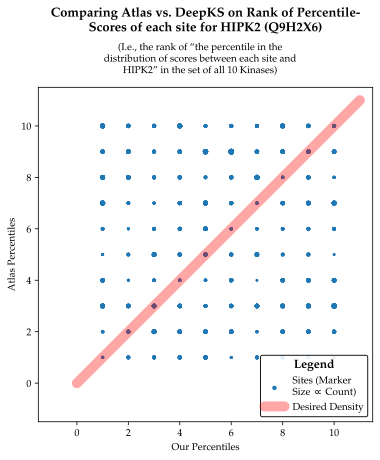

In [151]:
import random, textwrap as tw
fig = plt.figure(figsize=(6, 9))

KIN = str(their_ranks.columns[5])
inds = list(range(len(their_ranks[KIN])))
inds = random.sample(inds, k=1000)
_ = plt.gca().set_aspect(1)
X = our_ranks[KIN].tolist()
X = [X[i] for i in inds]
Y = their_ranks[KIN].tolist()
Y = [Y[i] for i in inds]
coord_to_count = collections.Counter((i, j) for i, j in zip(X, Y))
coord_to_size = {(i, j): coord_to_count[(i, j)] for i in range(1, 11) for j in range(1, 11)}
plt.scatter(X, Y, label="Sites (Marker\nSize ∝ Count)", marker='o', s=[coord_to_size[(i, j)] for i, j in zip(X, Y)])
plt.xlabel("Our Percentiles")
plt.ylabel("Atlas Percentiles")
nice_kin = KIN.replace("|['", " (").replace("]", "").replace("'", "").replace("^Rank^Pctl", "").replace("[", "") + ")"
the_title = tw.fill(f"Comparing Atlas vs. DeepKS on Rank of Percentile-Scores of each site for " + nice_kin, width=50, replace_whitespace=False)
the_subtitle = tw.fill("\n(I.e., the rank of “the percentile in the distribution of scores between each site and "+ nice_kin.split(" ")[0] + "” in the set of all 10 Kinases)", width=50, replace_whitespace=False)

plt.title(the_title, y = 1.15, fontdict={'weight': 'bold', 'size': 13})
plt.suptitle(the_subtitle, fontsize=10, y = 0.84)
plt.plot([0, 11], [0, 11], color='red', linestyle='-', linewidth=10, label='Desired Density', alpha=0.35, solid_capstyle='round')
_ = plt.legend(loc="lower right", shadow=False, fancybox=True, title="Legend", scatterpoints = 1, title_fontproperties = {'size': 12, 'weight': 'bold'}, edgecolor='black', framealpha=0.9)
plt.xlim(-1.5, 11.5)
plt.ylim(-1.5, 11.5)
fig.savefig("./rank_correlation.pdf", bbox_inches="tight")

In [90]:
their_ranks

,['ASK1']|['Q99683']^Rank^Pctl,['CDK16']|['Q00536']^Rank^Pctl,['CDK5']|['Q00535']^Rank^Pctl,['CDKL1']|['Q00532']^Rank^Pctl,['CK2A2']|['P19784']^Rank^Pctl,['HIPK2']|['Q9H2X6']^Rank^Pctl,['IRAK4']|['Q9NWZ3']^Rank^Pctl,['MAP3K15']|['Q6ZN16']^Rank^Pctl,['TAO3']|['Q9H2K8']^Rank^Pctl,['ZAK']|['Q9NYL2']^Rank^Pctl
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S24', 'S200']",6,10,7,5,1,4,9,8,2,3
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S35', 'S211']",7,4,5,3,1,2,6,9,8,10
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S57', 'S233']",3,4,6,9,1,10,7,8,5,2
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S68', 'S244']",3,9,8,7,6,10,1,5,4,2
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S71', 'S247']",4,3,6,9,7,10,1,5,8,2
...,...,...,...,...,...,...,...,...,...,...
['ZZZ3']|['Q8IYH5']|['S260'],4,10,9,5,2,8,6,7,3,1
['ZZZ3']|['Q8IYH5']|['S391'],9,4,1,5,10,2,7,6,3,8
['ZZZ3']|['Q8IYH5']|['S426'],10,2,1,4,6,3,9,8,5,7
['ZZZ3']|['Q8IYH5']|['S606'],5,3,4,1,9,2,6,8,7,10


In [10]:
len(X)

1000

In [11]:
derived_df

,['HIPK2']|['Q9H2X6']^Score^Pctl,['CDK16']|['Q00536']^Score^Pctl,['MAP3K15']|['Q6ZN16']^Score^Pctl,['CDKL1']|['Q00532']^Score^Pctl,['IRAK4']|['Q9NWZ3']^Score^Pctl,['CK2A2']|['P19784']^Score^Pctl,['CDK5']|['Q00535']^Score^Pctl,['TAO3']|['Q9H2K8']^Score^Pctl,['ZAK']|['Q9NYL2']^Score^Pctl,['ASK1']|['Q99683']^Score^Pctl
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S24', 'S200']",78.3,51.5,20.1,85.6,37.3,7.3,2.4,26.0,62.5,14.8
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S35', 'S211']",49.2,52.9,11.4,96.1,22.4,65.5,50.4,90.9,8.2,19.2
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S57', 'S233']",61.7,96.8,22.5,56.4,28.9,39.3,67.4,0.6,0.5,17.0
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S68', 'S244']",58.5,27.3,18.1,78.6,86.6,92.4,77.7,14.8,57.7,13.7
"['<UNK>UnipAc:A0A075B6Q4', 'LTV1']|['A0A075B6Q4', 'Q96GA3']|['S71', 'S247']",58.7,80.0,95.3,21.5,51.3,43.5,49.4,62.4,76.2,21.8
...,...,...,...,...,...,...,...,...,...,...
['ZZZ3']|['Q8IYH5']|['S260'],31.3,83.0,48.9,76.4,5.6,40.5,33.2,47.4,5.1,70.1
['ZZZ3']|['Q8IYH5']|['S391'],80.6,74.2,98.8,16.9,4.6,78.9,99.7,13.0,9.3,48.2
['ZZZ3']|['Q8IYH5']|['S426'],29.5,63.2,82.4,40.5,5.1,63.5,28.1,79.0,94.1,3.1
['ZZZ3']|['Q8IYH5']|['S606'],82.8,10.1,40.9,70.8,65.9,34.3,29.4,60.5,5.3,17.8


In [12]:
with open("/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/data/raw_data/PSP_script_download.xlsx", "rb") as xl:
    pd.Series([re.sub(r"^(.{8})", r"\1*", x.upper()) for x in pd.read_excel(xl)["SITE_+/-7_AA"]]).to_csv("./PSP_site_list.csv", header=False, index=False)

In [13]:
kin_uniprot_to_sites = collections.defaultdict(list[str])
psp = pd.read_excel("/Users/druc594/Library/CloudStorage/OneDrive-PNNL/Desktop/DeepKS_/DeepKS/data/raw_data/PSP_script_download.xlsx")[["SITE_+/-7_AA", "KIN_ACC_ID"]]
for _, row in psp.iterrows():
    assert isinstance(row["SITE_+/-7_AA"], str)
    kin_uniprot_to_sites[row["KIN_ACC_ID"]].append(re.sub(r"^(.{8})", r"\1*", row["SITE_+/-7_AA"].upper()))

In [14]:
mod_cols = set([matrix_name_to_uniprot_id[re.sub(r"^([0-9A-Z]+)_rank.*", r"\1", x)] for x in their_results.columns if x.endswith("_rank")])
kuts = kin_uniprot_to_sites.copy().keys()
for kin_u in kuts:
    if kin_u not in mod_cols:
        kin_uniprot_to_sites.pop(kin_u)

In [15]:
site_to_kin_uniprots = collections.defaultdict(list[str])
for kin_u, sites in kin_uniprot_to_sites.items():
    for site in sites:
        site_to_kin_uniprots[site].append(kin_u)

In [16]:
sorted(site_to_kin_uniprots.keys())

['AAAAKKGS*EQESVKE',
 'AAAFPTAS*PANKDVS',
 'AAAGGQGS*AVAAEAE',
 'AAAGPALS*PVPPVVH',
 'AAAGSGPS*PPCSPGH',
 'AAAGYGRS*PGSLSLH',
 'AAAHRKGS*SSNEPSS',
 'AAAKIQAS*FRGHMAR',
 'AAASLPSS*KEVAELK',
 'AAASQQGS*AKNGENT',
 'AAAVQQHS*ASQQHSA',
 'AADSGRGS*WTSCSSG',
 'AAEAAPPT*QEAQGET',
 'AAEEEDES*ILDTVIK',
 'AAEERRKS*HEAEVLK',
 'AAEGRRKS*QEAQVLK',
 'AAERPGGT*PTPVIAY',
 'AAGARPLT*SPESLSR',
 'AAGGTRGS*NHARIDA',
 'AAHDTEAT*ATDYHTT',
 'AAHGKRPS*IGDLEHV',
 'AAISRELS*EITTAEA',
 'AALARVSS*VKLISKA',
 'AALGGRAS*PGPPTPA',
 'AALHYPST*TALQEMV',
 'AALIQDQS*EEEEEEE',
 'AALKSWLS*RSVTSFF',
 'AALRQLRS*PRRAQAP',
 'AALSRAHS*PALGVHS',
 'AALVGGTT*MIIDHVV',
 'AAPAAPAS*EDEDEED',
 'AAPAPPPT*PQAPAAE',
 'AAPDADLS*QEPHLF_',
 'AAPEEAET*LAETEPE',
 'AAPEFPLS*PPKKKDL',
 'AAPEPERT*PVGQGSW',
 'AAPPAPPT*PPPPTLP',
 'AAPPPPSS*PLPSKST',
 'AAQDLVSY*LEGSTAS',
 'AAQGQLPS*CIATPYS',
 'AAQKALTT*PTHYKLT',
 'AAQMEVAS*FLLSKEN',
 'AAQQTKGS*YMEVEDN',
 'AAQRCTIS*YRAPELF',
 'AARARFES*KVPSFYY',
 'AARARLLT*EIHGGAG',
 'AAREMLHS*PLPCTGG',
 'AARERKRS*RG

In [20]:
site_samples = random.sample(site_to_kin_uniprots.keys(), k=20)
import requests
txt = []
for x in tqdm.tqdm(site_samples):
    r = requests.post(url = f"https://kinase-library.phosphosite.org/site?s={x}&pp=false&scp=true", data = "text/plain;charset=utf-8,kinase%09kinase_group%09score_raw%09score_log2%09score_rank%09site_percentile%09percentile_rank%0APHKG1%09CAMK%0912.898374309973203%093.6891173370679007%094%0999.5020245361697%091%0APKCH%09AGC%0913.947778972885985%093.8019635022528564%092%0999.48872907475675%092%0AULK2%09Other%093.732131090814167%091.8999996616307173%0922%0999.41379101952016%093%0AGCN2%09Other%094.409090860699541%092.1404812077157302%0919%0999.40049555810721%094%0ADRAK1%09CAMK%096.803607819995042%092.766299982204259%0913%0999.29413186680365%095%0APHKG2%09CAMK%0911.42887722055365%093.5146117742137615%096%0999.25303680425455%096%0APKN3%09AGC%0912.291926000555177%093.61963908169223%095%0999.22161116818758%097%0AMLK2%09TKL%094.0206347092423655%092.0074232674727748%0921%0998.93998912189521%098%0APKN2%09AGC%0910.274482421795847%093.360993814700323%097%0998.88076388469209%099%0APKCI%09AGC%099.028197796676334%093.174438026544601%099%0998.86263371003807%0910%0APKN1%09AGC%0913.23269607215098%093.7260351257899953%093%0998.77681755000907%0911%0APKCE%09AGC%0910.179790486395689%093.3476359640270594%098%0998.62694143953587%0912%0ANEK9%09Other%093.2013390500706116%091.6786754791178389%0927%0998.46376986764972%0913%0AMST3%09STE%093.4562204845246294%091.7891952550546093%0925%0998.35498881972563%0914%0AMLK1%09TKL%094.0858245954919274%092.0306272704818844%0920%0998.28730283435064%0915%0APKCT%09AGC%097.304331711251072%092.8687522838476545%0911%0998.27400737293769%0916%0ATTBK2%09CK1%092.9053271178869644%091.538700609338706%0929%0998.25708587659395%0917%0APKCA%09AGC%098.084232854673187%093.0151108770669928%0910%0998.23774702362967%0918%0APKCG%09AGC%096.957688690876163%092.7986081296366456%0912%0998.21599081404484%0919%0AYSK1%09STE%091.6492626263401542%090.7218211498669531%0951%0998.14709615035959%0920%0APKCZ%09AGC%095.950153137587845%092.5729267991761295%0914%0997.95854233395782%0921%0ANEK3%09Other%091.6996677406767158%090.7652527488761156%0948%0997.92228198464979%0922%0AERK7%09CMGC%0914.432686589055505%093.851267971843313%091%0997.83404846800025%0923%0ANEK2%09Other%093.344256273991793%091.741685406943462%0926%0997.65395539977035%0924%0AMST4%09STE%095.007980007881964%092.324228802967992%0915%0997.50528796760743%0925%0APKCB%09AGC%094.94562752577325%092.3061535889080247%0917%0997.36870731854717%0926%0AWNK1%09Other%094.939163089956362%092.304266606940011%0918%0997.32398622106726%0927%0ANEK11%09Other%091.301099842686728%090.3797316746015677%0970%0997.21278781652262%0928%0AYSK4%09STE%092.034387813098053%091.024594724771573%0942%0997.18498821538647%0929%0AULK1%09Other%091.6003620089514108%090.6783982860156257%0953%0997.1801535021454%0930%0ATTBK1%09CK1%091.9719011193255753%090.9795872098115292%0944%0997.15356257931951%0931%0AZAK%09TKL%091.6779789241749468%090.7467245952895124%0949%0997.00852118208739%0932%0APKCD%09AGC%094.972833390399165%092.3140680959563866%0916%0996.84051489696017%0933%0AIRE1%09Other%092.637049333811008%091.3989245613347174%0931%0996.7353598839669%0934%0AANKRD3%09TKL%091.7854897047207765%090.8363198152507207%0946%0996.63987429745573%0935%0AHRI%09Other%091.6027506852990088%090.6805500255819407%0952%0996.00773554118571%0936%0APDK1%09AGC%091.401061777822697%090.4865205707533555%0965%0995.8542333957817%0937%0AMEKK6%09STE%091.129242064794515%090.1753547759655335%0981%0995.65963618782861%0938%0ANEK7%09Other%092.01499207686084%091.010774165951234%0943%0995.6149150903487%0939%0APERK%09Other%091.463620428493991%090.5495414573578903%0958%0995.54118571342237%0940%0APKR%09Other%091.4386099204641773%090.5246754578863744%0960%0995.40702242098266%0941%0ACHAK1%09Alpha%092.2515148140549512%091.170895970059639%0939%0995.0045325436635%0942%0ANEK6%09Other%092.35083073534116%091.2331706657135848%0936%0994.97915029914789%0943%0ADSTYK%09TKL%092.8270168703073826%091.499280492520407%0930%0994.94168127152959%0944%0AEEF2K%09Alpha%091.0976423496702008%090.13440805032646042%0983%0994.91871638363449%0945%0ANEK8%09Other%090.9952954726327655%09-0.006803213832591304%0996%0994.73741463709435%0946%0AMLK4%09TKL%091.5429043697438067%090.6256486454654387%0956%0994.20438750226627%0947%0AMAP3K15%09STE%090.8041841385301979%09-0.3144022137223472%09113%0993.85145343566809%0948%0ACAMK2D%09CAMK%093.5232914144195244%091.8169238062977295%0924%0993.7656372756391%0949%0ATAO1%09STE%090.5978538518037276%09-0.7421352409777002%09145%0993.68707318547169%0950%0AMEKK1%09STE%091.0133034820191087%090.01906632264111524%0992%0993.64235208799178%0951%0ANIK%09STE%092.45342808733971%091.294798985056498%0934%0993.53115368344716%0952%0APRPK%09Other%091.4161573832805223%090.5019816068481929%0964%0993.4622590197619%0953%0ACAMK1G%09CAMK%092.916707481419303%091.544340704622404%0928%0993.32809572732216%0954%0ALOK%09STE%091.006453266685799%090.009280184195724364%0994%0993.32446969239136%0955%0AHUNK%09CAMK%091.4358884446626152%090.5219436693673289%0961%0993.28820934308334%0956%0ANEK4%09Other%090.8519477792925855%09-0.23116309268100813%09109%0993.00658729679095%0957%0APDHK1%09PDHK%091.4216147811445985%090.5075305868824008%0963%0992.93648395479543%0958%0AMNK1%09CAMK%092.5037411690347766%091.3240854275059002%0932%0992.91351906690034%0959%0ATAO2%09STE%090.7830620488876525%09-0.35280146543518265%09119%0992.76364295642715%0960%0ARIPK2%09TKL%090.6085346087061813%09-0.7165887803642286%09143%0992.72738260711911%0961%0AMNK2%09CAMK%092.457450373443021%091.2971622826042846%0933%0992.5364114340968%0962%0ANEK1%09Other%090.6695231375346549%09-0.5787941814890618%09131%0992.01788843899196%0963%0AIRAK4%09TKL%091.5196918026869575%090.6037787711566145%0957%0992.0166797606817%0964%0ASGK3%09AGC%093.725177593027024%091.8973092058357348%0923%0992.00338429926876%0965%0AWNK4%09Other%091.5720852947560031%090.6526794943034109%0955%0991.98767148123527%0966%0ATAK1%09TKL%090.484843946909496%09-1.0444076223246739%09167%0991.9792107330634%0967%0ARIPK3%09TKL%091.3924194258560874%090.4775938465735055%0966%0991.83537801414154%0968%0ASTK33%09CAMK%090.9421328285609317%09-0.08599761934149683%0997%0991.78703088173083%0969%0AMINK%09STE%090.5812855473065758%09-0.7826810560721462%09146%0991.304768235934%0970%0AMLK3%09TKL%091.2899077674430575%090.3672679119976545%0972%0991.21290868435365%0971%0ARAF1%09TKL%091.6731077432451071%090.7425303537088039%0950%0991.06907596543181%0972%0ASNRK%09CAMK%090.8870811089359074%09-0.17286207366443299%09106%0991.03523297274431%0973%0AIRE2%09Other%091.2273504226713698%090.29554721385226357%0976%0990.77657581434701%0974%0ACAMKK1%09Other%090.6079448154380405%09-0.7179877220526455%09144%0990.33782558771983%0975%0ANUAK2%09CAMK%092.388556573918671%091.2561390480234613%0935%0990.23750528796761%0976%0AMEK2%09STE%090.30721795077937436%09-1.702665579532161%09209%0989.92204024898773%0977%0AMELK%09CAMK%091.9380326159864758%090.9545928506941634%0945%0989.58361032211278%0978%0ACAMK4%09CAMK%091.577616275984586%090.6577463409316069%0954%0988.68193630265306%0979%0AHGK%09STE%090.5297286976340045%09-0.9166744272700271%09157%0988.17308273403034%0980%0APRKD3%09CAMK%092.1958620112506617%091.1347873977223324%0940%0988.04738018976249%0981%0AOSR1%09STE%090.3587021493582991%09-1.4791417048769293%09195%0987.9796942043875%0982%0ATBK1%09Other%091.2706307814604951%090.3455448744500645%0973%0987.89266936604822%0983%0AMTOR%09PIKK%092.290464526175309%091.1956402191286677%0937%0987.86970447815314%0984%0ANUAK1%09CAMK%091.2224218458463807%090.2897422310555216%0977%0987.76092343022904%0985%0ATAO3%09STE%090.889999715080258%09-0.1681232206649164%09104%0987.51797908986522%0986%0ATNIK%09STE%090.5517711373650843%09-0.8578581022580017%09153%0987.34876412642775%0987%0AMEKK3%09STE%090.6919042153177016%09-0.5313557646132665%09128%0987.10219375113314%0988%0AP70S6K%09AGC%091.2595021459956626%090.33285358020209677%0974%0986.72146008339881%0989%0APAK6%09STE%091.025084942325294%090.03574346172488817%0991%0986.65981748957515%0990%0AHPK1%09STE%090.4982975798535487%09-1.0049205277729256%09163%0986.5268628754457%0991%0ARSK3%09AGC%091.714260408060007%090.7775862814926642%0947%0986.50148063093009%0992%0ACK1G1%09CK1%091.013283481977531%090.019037847217839174%0993%0985.8040732459056%0993%0ADCAMKL2%09CAMK%091.1524981836379713%090.20476447693786157%0980%0985.77869100138999%0994%0ADLK%09TKL%091.000874127483649%090.0012605485259398752%0995%0985.57200701033419%0995%0AIKKE%09Other%090.840521084260042%09-0.2506440853296861%09110%0985.35202755786547%0996%0AMASTL%09AGC%090.8205910158274837%09-0.28526473579716416%09112%0985.10666586088112%0997%0AMYO3B%09STE%090.25171567455433064%09-1.9901330377142468%09225%0984.9652504985798%0998%0ACAMK2A%09CAMK%092.2715568197000797%091.1836813927705292%0938%0984.93261618420257%0999%0ACAMK1B%09CAMK%092.0450790309754363%091.0321565964155504%0941%0984.92536411434098%09100%0ABCKDK%09PDHK%090.6575213617656026%09-0.6048903289802579%09135%0984.55550855139904%09101%0APDHK4%09PDHK%091.0607265307719387%090.08505275846507648%0987%0984.5313349851937%09102%0AKHS2%09STE%090.43535645209898327%09-1.1997309902618734%09175%0984.52650027195261%09103%0APLK1%09Other%091.0869679654970386%090.12030942270231564%0984%0984.519248202091%09104%0AMEK5%09STE%090.4850371682332719%09-1.0438327901211364%09166%0984.37662416147941%09105%0AAKT1%09AGC%091.052816870058903%090.07425451173454028%0989%0984.35970266513567%09106%0AAKT2%09AGC%091.3598539231464586%090.44345168407048907%0967%0984.20257448480088%09107%0AAURC%09Other%090.9320191916296936%09-0.10156843251433162%09100%0984.18807034507766%09108%0ASSTK%09CAMK%090.7891053651249581%09-0.34171014624016993%09115%0984.18444431014686%09109%0ACAMK1A%09CAMK%090.7676078023204271%09-0.3815587190604528%09122%0983.80008460748172%09110%0AAKT3%09AGC%090.723078335179747%09-0.46777614390264954%09126%0983.76019822324288%09111%0ANEK5%09Other%090.6178478884475244%09-0.6946763984957502%09140%0983.55109687556657%09112%0AWNK3%09Other%090.8374569860170603%09-0.25591300312037135%09111%0983.32265667492597%09113%0AATR%09PIKK%091.1214103920945337%090.16531434441372578%0982%0983.30090046534116%09114%0AMRCKB%09AGC%090.7113021148664497%09-0.49146564187235975%09127%0983.26222275941258%09115%0APRKD2%09CAMK%091.4492651854505259%090.5353216022999465%0959%0983.24771861968937%09116%0AROCK1%09AGC%090.4246813115025018%09-1.235547471947028%09178%0982.93467093733004%09117%0AMAPKAPK5%09CAMK%090.6668707284342162%09-0.5845209699422546%09133%0982.86215023871397%09118%0AKHS1%09STE%090.40226281691147436%09-1.3137897060081456%09182%0982.8005076448903%09119%0AAURB%09Other%090.6786950292265189%09-0.5591646480460876%09129%0982.78962954009789%09120%0AASK1%09STE%090.17872308593561761%09-2.484202093335906%09249%0982.70018734513809%09121%0ACAMK2G%09CAMK%091.3119969414700718%090.3917643567463146%0968%0982.24088958723635%09122%0AMAPKAPK3%09CAMK%091.2509257037080166%090.3229961059905306%0975%0982.23363751737475%09123%0AVRK1%09CK1%090.2333581788498737%09-2.099382062428367%09230%0982.18529038496403%09124%0ACAMKK2%09Other%090.38281457222345805%09-1.3852823463738302%09187%0981.82631292681452%09125%0AP70S6KB%09AGC%091.2120735281930155%090.27747721988497953%0978%0980.85937027860035%09126%0AMYLK4%09CAMK%090.7305217000676822%09-0.4530009661227252%09125%0980.2997522209464%09127%0AMST1%09STE%090.22675012666277009%09-2.1408247382429395%09233%0980.05318184565178%09128%0ASGK1%09AGC%090.7848459896606242%09-0.3495185131781371%09117%0980.03142563606697%09129%0ASTLK3%09STE%090.07766134246273293%09-3.6866595437234446%09287%0980.01813017465402%09130%0APKG2%09AGC%090.6093982225525351%09-0.7145428028025484%09142%0980.00966942648215%09131%0APLK4%09Other%090.2973099202442278%09-1.7499604928985182%09212%0979.84287181966519%09132%0AMYO3A%09STE%090.14257043172901235%09-2.810253288569271%09268%0979.4343385507947%09133%0ASLK%09STE%090.31547884095304285%09-1.664384847447454%09205%0979.28083640539072%09134%0AAURA%09Other%090.4532816719616781%09-1.141520266565656%09172%0979.1684293225358%09135%0ATGFBR2%09TKL%090.6369481547755429%09-0.6507521476683125%09137%0979.12854293829697%09136%0APAK3%09STE%090.6327557537450135%09-0.6602793738447151%09138%0977.62373844201366%09137%0ABIKE%09Other%090.14900435508708354%09-2.7465735966112224%09265%0977.48957514957394%09138%0APIM1%09CAMK%091.0734694947583332%090.10228119409730105%0986%0977.24542213089987%09139%0AsmMLCK%09CAMK%090.47035207384132377%09-1.0881870295131677%09171%0976.95413065812534%09140%0AROCK2%09AGC%090.3616932626823936%09-1.467161369952083%09193%0976.88523599444008%09141%0APKG1%09AGC%090.15912867153808793%09-2.6517342934162875%09261%0976.85260168006285%09142%0ATSSK2%09CAMK%090.7758809167849712%09-0.36609285220073684%09120%0976.64591768900706%09143%0AIKKB%09Other%090.9185053692078918%09-0.12263994011910051%09101%0976.641082975766%09144%0ADNAPK%09PIKK%090.7430948174765444%09-0.42838178725190895%09124%0976.57702302532181%09145%0APRKD1%09CAMK%091.0839761639051346%090.11633303289663366%0985%0976.49725025684414%09146%0AIRAK1%09TKL%090.34343402639398596%09-1.541895110649373%09199%0976.3896778872303%09147%0AMPSK1%09Other%090.6388045401261871%09-0.646553528546703%09136%0976.30869644044238%09148%0ALRRK2%09TKL%090.2739763434569882%09-1.8678767661201396%09222%0975.90620656312322%09149%0AMST2%09STE%090.22532889714557003%09-2.149895752040795%09234%0975.78896476702725%09150%0ARSK2%09AGC%090.8522771410584251%09-0.23060545667125734%09108%0975.49767329425273%09151%0APAK1%09STE%090.5790217733837968%09-0.7883104949246491%09147%0975.24626820571704%09152%0AMEK1%09STE%090.4709571597734236%09-1.0863322626361078%09170%0975.0794705989001%09153%0ADCAMKL1%09CAMK%090.7726806668676006%09-0.37205579394863464%09121%0975.06859249410769%09154%0AP90RSK%09AGC%090.7834491097034212%09-0.35208852990614625%09118%0974.77730102133317%09155%0APLK3%09Other%090.6689452158310794%09-0.580040030635196%09132%0974.6189641626881%09156%0ACDK10%09CMGC%091.4318515123966038%090.5178818882471126%0962%0974.5476521423823%09157%0ACDKL5%09CMGC%091.2951749430097164%090.37314698004797286%0971%0974.49326161842026%09158%0APAK4%09STE%090.18052358111477165%09-2.469740791651551%09247%0974.14153623013236%09159%0AAMPKA2%09CAMK%090.6307350864206005%09-0.6648939054597176%09139%0973.78255877198283%09160%0APKACG%09AGC%090.4886332595033609%09-1.0331760288927163%09165%0973.64356076630204%09161%0ABRSK2%09CAMK%090.3084892013773144%09-1.6967081059731757%09208%0973.6193872000967%09162%0APIM2%09CAMK%090.5605259451419922%09-0.8351469420861185%09151%0973.42599867045386%09163%0ACAMK2B%09CAMK%090.9333976361813296%09-0.09943628118911088%0999%0973.40907717411011%09164%0ACHK2%09CAMK%090.2943448890803481%09-1.764420517559281%09214%0973.2446969239137%09165%0AYANK2%09AGC%090.508413016874942%09-0.9759271268172662%09162%0972.96186619931106%09166%0AQIK%09CAMK%090.4286920613977966%09-1.2219863935898923%09177%0972.75880824318608%09167%0ARIPK1%09TKL%090.5614071631442035%09-0.8328806231874583%09150%0972.7575995648758%09168%0ACK1E%09CK1%090.8815955511126988%09-0.18181115138192355%09107%0972.6113494893334%09169%0ANIM1%09CAMK%090.4154491531916719%09-1.2672561784864065%09180%0972.5182812594428%09170%0APAK5%09STE%090.1815944790971673%09-2.4612077529425314%09246%0971.99613222940714%09171%0APKACA%09AGC%090.22439497716878287%09-2.1558877116981834%09235%0971.5634253943313%09172%0ATSSK1%09CAMK%090.5516897612095643%09-0.8580708890932759%09154%0971.30597691424427%09173%0ABUB1%09Other%090.28736223697310737%09-1.7990576089835015%09216%0971.10412763642955%09174%0ACK1G3%09CK1%090.5157228170830593%09-0.9553322188977011%09160%0970.8333836949296%09175%0AMSK2%09AGC%090.3696260767648516%09-1.4358615537928987%09189%0970.6943856892488%09176%0ACDK9%09CMGC%091.2007111479938892%090.2638891273316204%0979%0970.4103462863359%09177%0ABMPR2%09TKL%090.9005279301848066%09-0.15115707237687984%09102%0969.86281501178462%09178%0AGCK%09STE%090.23936981532974608%09-2.0626868558041047%09228%0969.57031486069982%09179%0ACK1A%09CK1%090.6105470627415783%09-0.7118255882627881%09141%0969.54009790294313%09180%0ACAMK1D%09CAMK%090.32440266461422734%09-1.6241424251165673%09201%0969.44944702967305%09181%0ACRIK%09AGC%090.16285700451838575%09-2.6183223231632584%09257%0969.03366169094095%09182%0AAMPKA1%09CAMK%090.5324084539600038%09-0.9093946153179848%09156%0968.79676074212848%09183%0ADAPK1%09CAMK%090.2552558415416964%09-1.9699841172639987%09224%0968.67951894603252%09184%0AMEKK2%09STE%090.3212942221054225%09-1.6380330581017064%09202%0968.52480812231825%09185%0APAK2%09STE%090.32095892806030013%09-1.6395394021343008%09203%0967.94826856832054%09186%0ACK1A2%09CK1%090.8997037610701981%09-0.15247804098702677%09103%0967.89508672266876%09187%0AHASPIN%09Other%090.13551134344964016%09-2.883514472433139%09270%0967.52523115972684%09188%0ACDK6%09CMGC%090.8899256145103598%09-0.16824334314758882%09105%0966.94385689248806%09189%0ARSK4%09AGC%090.3608757603544126%09-1.4704258527076852%09194%0966.88342297697469%09190%0AMRCKA%09AGC%090.20230784244530653%09-2.3053758479637256%09240%0966.8302411313229%09191%0AGAK%09Other%090.19521018932734036%09-2.3568997361035247%09242%0966.64531334985195%09192%0ACHAK2%09Alpha%090.479255823449997%09-1.0611321326624015%09168%0966.49422856106847%09193%0AcaMLCK%09CAMK%090.6751737781168368%09-0.5666692200416166%09130%0966.28270985677162%09194%0ADMPK1%09AGC%090.1271578120671159%09-2.9753079967266256%09274%0965.4741040672025%09195%0ANDR1%09AGC%090.3958837475743331%09-1.3368512540290838%09185%0964.97008521182087%09196%0ADAPK2%09CAMK%090.6658597148929415%09-0.5867098364296475%09134%0964.85163473741463%09197%0AERK5%09CMGC%091.0599930871652068%090.08405485616112081%0988%0963.0930077959751%09198%0ACDC7%09Other%090.5700941182834259%09-0.8107279777649342%09149%0962.989061461292074%09199%0AMAPKAPK2%09CAMK%090.37525886119845997%09-1.4140419554700852%09188%0962.89720190971173%09200%0ACDK4%09CMGC%090.5087216443695721%09-0.9750516176312853%09161%0962.62162325497069%09201%0ANLK%09CMGC%091.3095835191830445%090.3891080710431344%0969%0962.39197437601982%09202%0ABRAF%09TKL%090.2896232527388716%09-1.7877506593710895%09215%0962.388348341089014%09203%0ACDK12%09CMGC%090.5435899867414791%09-0.8794092138583334%09155%0962.1756209584819%09204%0ACK1G2%09CK1%090.3671812185621892%09-1.4454358285652718%09191%0961.78642654257569%09205%0AMSK1%09AGC%090.2401997411641842%09-2.057693498470581%09227%0961.57128180334804%09206%0ACDK13%09CMGC%090.49489222045238707%09-1.0148137312093732%09164%0961.15307910799541%09207%0ACDKL1%09CMGC%090.788339031661113%09-0.3431118889287682%09116%0961.1119840454463%09208%0ACDK16%09CMGC%090.3998252831889305%09-1.3225583902436036%09183%0961.099897262343625%09209%0AAAK1%09Other%090.04965578274841579%09-4.3318944507389165%09296%0960.68290324530127%09210%0ASIK%09CAMK%090.18050418562960974%09-2.469895803386731%09248%0960.40611591224996%09211%0ACDK2%09CMGC%090.3502943849166234%09-1.513360232405017%09196%0960.08339880340847%09212%0AERK1%09CMGC%090.5754149881570465%09-0.7973252946335497%09148%0959.977035112104915%09213%0ACDK18%09CMGC%090.476567710225353%09-1.0692468896367175%09169%0959.19743760198223%09214%0ACK1D%09CK1%090.9342606818332037%09-0.09810294118935245%0998%0959.164803287605004%09215%0ACDK14%09CMGC%090.5205734345403672%09-0.941826403650064%09159%0958.98954493261619%09216%0AYANK3%09AGC%090.5524705096582062%09-0.8560306379948055%09152%0958.19423460446003%09217%0ALATS2%09AGC%090.28416061292769274%09-1.8152214962244133%09217%0958.122922584154225%09218%0ACDK5%09CMGC%090.526571661884232%09-0.9252982118610752%09158%0958.11929654922342%09219%0APKACB%09AGC%090.14390513135167832%09-2.796810058447577%09267%0957.96337704719888%09220%0APLK2%09Other%090.20210881915408985%09-2.306795818828941%09241%0957.95975101226809%09221%0APRKX%09AGC%090.10971011178506303%09-3.188231592392755%09279%0957.875143530549344%09222%0ADAPK3%09CAMK%090.1349533415526039%09-2.889467395357988%09271%0956.66163050704055%09223%0ACOT%09STE%090.7432652165957201%09-0.4280510006865434%09123%0955.912249954674564%09224%0AERK2%09CMGC%090.42111440178431137%09-1.2477158794907406%09179%0955.89653713664108%09225%0ACDK17%09CMGC%090.24446996579423746%09-2.03227086022623%09226%0955.58469813259202%09226%0AACVR2A%09TKL%090.31058396858329423%09-1.68694473084882%09207%0953.8550794705989%09227%0ACHK1%09CAMK%090.31898761380090923%09-1.6484276892512402%09204%0953.830905904393546%09228%0AP38G%09CMGC%090.296653669963831%09-1.7531484641006878%09213%0953.219314679398074%09229%0ATLK1%09Other%090.18405832023986612%09-2.4417651275751524%09245%0953.06218649906328%09230%0APINK1%09Other%090.36416028625453517%09-1.4573544980742215%09192%0951.76164863721521%09231%0ASBK%09Other%090.15929034493534133%09-2.650269271439348%09260%0951.748353175802265%09232%0AICK%09CMGC%090.7952091743610581%09-0.3305936934589307%09114%0951.34102858524204%09233%0ALKB1%09CAMK%090.16990437174716558%09-2.5572051204299004%09254%0951.31202030579561%09234%0AP38A%09CMGC%090.3970771829588562%09-1.3325086324834645%09184%0949.756451320481055%09235%0AP38B%09CMGC%090.27888692173255636%09-1.842247813421744%09220%0949.51471565842751%09236%0ABRSK1%09CAMK%090.09340263136643641%09-3.420392995237717%09282%0949.17628573155255%09237%0ACDK3%09CMGC%090.1201973974457366%09-3.0565224362157855%09276%0949.14486009548559%09238%0AHIPK3%09CMGC%090.44358157672190707%09-1.1727286476111174%09174%0948.33504562760621%09239%0ACLK1%09CMGC%090.27918997868337975%09-1.8406809368758372%09219%0948.26010757236961%09240%0AVRK2%09CK1%090.34791705092533615%09-1.5231847097420714%09197%0947.79476642291654%09241%0AGSK3B%09CMGC%091.0260304269385487%090.03707351470955511%0990%0946.93056143107512%09242%0ASMG1%09PIKK%090.21490018664959806%09-2.2182613590814957%09236%0946.806067565117544%09243%0ACDK8%09CMGC%090.22706186842730652%09-2.138842647097954%09231%0945.85000302169577%09244%0ATTK%09Other%090.03344109228742694%09-4.902234218793788%09298%0944.66549827763341%09245%0AJNK2%09CMGC%090.306015963477965%09-1.7083211810877752%09210%0944.66549827763341%09246%0ASRPK1%09CMGC%090.3106776395628988%09-1.6865096849454426%09206%0944.30289478455309%09247%0ACDK19%09CMGC%090.15287283871669582%09-2.7095959925026225%09263%0943.86777059285671%09248%0AMOK%09CMGC%090.16271846985886204%09-2.6195500770579923%09258%0943.57043572853085%09249%0ATLK2%09Other%090.2126972592920122%09-2.2331266512986834%09238%0943.55593158880764%09250%0AGRK3%09AGC%090.3444483698215958%09-1.537640344714113%09198%0943.34924759775186%09251%0ACDK1%09CMGC%090.17154842302871115%09-2.5433122310093697%09252%0942.55998066114704%09252%0AALK4%09TKL%090.38440461610885573%09-1.379302434120735%09186%0942.113978364658244%09253%0ATGFBR1%09TKL%090.3301732546116224%09-1.5987048341211287%09200%0941.90850305191273%09254%0APIM3%09CAMK%090.3047618638902359%09-1.7142457111462033%09211%0941.71632320058016%09255%0AMARK4%09CAMK%090.17459825568267812%09-2.5178889490386838%09250%0941.082975765999876%09256%0ACDK7%09CMGC%090.21261525857632457%09-2.233682957649273%09239%0940.70586813319635%09257%0AJNK3%09CMGC%090.2819998185649414%09-1.8262338604744408%09218%0939.921435909832596%09258%0AMARK3%09CAMK%090.06642955138554558%09-3.9120310181856466%09289%0939.6966217441228%09259%0APBK%09Other%090.07812429543755259%09-3.678084915971292%09286%0938.999214359098325%09260%0AALK2%09TKL%090.17209301742984562%09-2.538739532800932%09251%0938.62694143953587%09261%0AGRK4%09AGC%090.1662254335612236%09-2.588786954262959%09255%0937.99359400495558%09262%0ANDR2%09AGC%090.1581809163113918%09-2.6603525380832416%09262%0937.84492657279265%09263%0ASRPK3%09CMGC%090.1934208418067899%09-2.370184836002019%09243%0937.82679639813863%09264%0AATM%09PIKK%090.21384881573716977%09-2.2253368770808457%09237%0937.101589411978004%09265%0ADYRK3%09CMGC%090.12298504073882842%09-3.023445250578086%09275%0936.96863479784855%09266%0AQSK%09CAMK%090.08189648312118857%09-3.6100546901985604%09284%0936.8284281138575%09267%0AMARK1%09CAMK%090.05398912150859532%09-4.211187447807045%09294%0935.543603070042906%09268%0AGRK6%09AGC%090.2748879863731524%09-1.8630842377949792%09221%0935.51096875566568%09269%0AKIS%09Other%090.1481167825147888%09-2.7551929790470786%09266%0935.17616486372152%09270%0AGRK5%09AGC%090.40594285628533433%09-1.300651438304529%09181%0935.045627606212605%09271%0ACLK4%09CMGC%090.17039710461846358%09-2.5530272733381234%09253%0934.77367498640237%09272%0AP38D%09CMGC%090.11829148369827272%09-3.079581883158383%09278%0934.48117483531758%09273%0ADYRK1A%09CMGC%090.15262250317786136%09-2.7119604011972513%09264%0934.438871094458214%09274%0AHIPK1%09CMGC%090.1889535997880821%09-2.4038960909920872%09244%0933.8139844080498%09275%0AACVR2B%09TKL%090.16413628617644346%09-2.607033879193591%09256%0933.57708345923732%09276%0AMAK%09CMGC%090.07601023722952305%09-3.7176624527231574%09288%0933.40303378255877%09277%0AGRK1%09AGC%090.2388019330719561%09-2.066113579800402%09229%0933.21689732277754%09278%0AGRK2%09AGC%090.4488549149377955%09-1.1556789023144816%09173%0932.91231038859008%09279%0ASRPK2%09CMGC%090.10098153417564783%09-3.3078365938792142%09281%0931.55254728953889%09280%0ALATS1%09AGC%090.22688428489978038%09-2.139971410435619%09232%0930.29431316855019%09281%0AMARK2%09CAMK%090.053836824045636535%09-4.215262885115441%09295%0929.995769625914065%09282%0AskMLCK%09CAMK%090.16090305454436754%09-2.6357363807950374%09259%0927.214600833988033%09283%0AFAM20C%09FAM20%090.026227279811948362%09-5.252788004944109%09300%0925.741221973771683%09284%0AHIPK2%09CMGC%090.061907620331214934%09-4.013739185223701%09291%0925.720674442497128%09285%0ACLK2%09CMGC%090.08295205468619474%09-3.5915784732244314%09283%0924.463648999818698%09286%0AJNK1%09CMGC%090.11832586648207971%09-3.0791626081390184%09277%0924.416510545718257%09287%0AIKKA%09Other%090.06435782329279617%09-3.957740657650497%09290%0923.553514232187105%09288%0AHIPK4%09CMGC%090.12902992016695097%09-2.9542224503911685%09272%0923.042243306943856%09289%0AGRK7%09AGC%090.264971179566733%09-1.9160926459938272%09223%0921.822686891883723%09290%0ABMPR1A%09TKL%090.055190780447071715%09-4.179428903100723%09293%0920.22964887895087%09291%0AMOS%09Other%090.4348212060666938%09-1.2015057931117963%09176%0919.838037106424125%09292%0ABMPR1B%09TKL%090.1361961348890599%09-2.876242333207776%09269%0919.00163171571886%09293%0APASK%09CAMK%090.12851472345058002%09-2.9599944418315283%09273%0918.55683809754034%09294%0ADYRK2%09CMGC%090.08116314516720681%09-3.6230314174695337%09285%0917.210370459902098%09295%0ACK2A1%09Other%090.015133765642937868%09-6.046085180511781%09302%0916.832054148788302%09296%0AAlphaK3%09Alpha%090.01823201258984027%09-5.777382363827314%09301%0915.190669003444734%09297%0ACK2A2%09Other%090.01415082997271345%09-6.142969517466523%09303%0914.726536532301928%09298%0ACLK3%09CMGC%090.10955807616420188%09-3.1902322571809973%09280%0912.091617815918292%09299%0AGSK3A%09CMGC%090.36912223992158827%09-1.4378294311104542%09190%0911.969541306581254%09300%0ADYRK1B%09CMGC%090.03458899180199028%09-4.853543227045868%09297%0911.906690034447331%09301%0ADYRK4%09CMGC%090.027060048792401543%09-5.207691749111706%09299%097.65697709554602%09302%0APRP4%09CMGC%090.061883243169167344%09-4.014307382427552%09292%095.68320541487883%09303%0A")
    if r.status_code != 200:
        print(f"Failed to get {x} — {r.status_code}")
    txt.append(r.text)

/var/folders/2t/m32pzsyn36x0x6gjjlpl5l0m0000gn/T/ipykernel_27711/3617400847.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  site_samples = random.sample(site_to_kin_uniprots.keys(), k=20)
  5%|▌         | 1/20 [00:00<00:14,  1.30it/s]

Failed to get SSTVAGGS*QSPKLFS — 405


 10%|█         | 2/20 [00:01<00:13,  1.32it/s]

Failed to get NAPAGQET*QRGGSKS — 405


 15%|█▌        | 3/20 [00:02<00:12,  1.33it/s]

Failed to get PPPSVGGS*RQRFCRC — 405


 20%|██        | 4/20 [00:03<00:13,  1.18it/s]

Failed to get VRTDSVKT*PESEGNP — 405


 25%|██▌       | 5/20 [00:04<00:12,  1.23it/s]

Failed to get RQRKGTLS*VNFVDLY — 405


 30%|███       | 6/20 [00:04<00:11,  1.26it/s]

Failed to get TGKDKKGS*CNLSRVD — 405


 35%|███▌      | 7/20 [00:05<00:10,  1.28it/s]

Failed to get TARTQIGS*KFTRWGS — 405


 40%|████      | 8/20 [00:06<00:09,  1.30it/s]

Failed to get KKTVDKLS*DEYKMRR — 405


 45%|████▌     | 9/20 [00:07<00:08,  1.30it/s]

Failed to get SHGSSACS*QPHGSVT — 405


 50%|█████     | 10/20 [00:08<00:08,  1.20it/s]

Failed to get TRSARRRT*TQIINIT — 405


 55%|█████▌    | 11/20 [00:08<00:07,  1.24it/s]

Failed to get NKQSLTQT*PGREPST — 405


 60%|██████    | 12/20 [00:09<00:06,  1.27it/s]

Failed to get PSKDTNES*PWRSDLL — 405


 65%|██████▌   | 13/20 [00:10<00:05,  1.29it/s]

Failed to get IGHLQTLS*PDMQGAY — 405


 70%|███████   | 14/20 [00:10<00:04,  1.32it/s]

Failed to get PLSKLLGS*LDEVVLL — 405


 75%|███████▌  | 15/20 [00:11<00:03,  1.33it/s]

Failed to get DGSEPTKT*PGRTSST — 405


 80%|████████  | 16/20 [00:12<00:03,  1.33it/s]

Failed to get ARHLQENT*QSHMRML — 405


 85%|████████▌ | 17/20 [00:13<00:02,  1.14it/s]

Failed to get SSLPYLHS*PITTSPS — 405


 90%|█████████ | 18/20 [00:14<00:01,  1.20it/s]

Failed to get IDETTELS*S______ — 405


 95%|█████████▌| 19/20 [00:15<00:00,  1.23it/s]

Failed to get GGHQVPGS*PFKVPVH — 405


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]

Failed to get YRSQRGHS*RGRNQNS — 405


In [19]:
import io
pd.read_html(io.StringIO(txt[0]), attrs={"id":"siteResultTable_wrapper"})

ValueError: No tables found